In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import xavierUtils as xu
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
import matplotlib.colors as colors 
from matplotlib.patches import Patch
%autosave 1000000

Autosaving every 1000000 seconds


### Funções 

In [95]:
import datetime as dt

def saveFigWdate(name):
    part = name.split('.')
    t = dt.datetime.now().strftime('%Y-%m-%d')
    filename = part[0]+'_'+t+'.'+part[1]
    pl.savefig(filename, bbox_inches='tight')

### Carrega dados

In [2]:
initial_date = '2019-02-01'
final_date   = '2019-04-15'
query = 'SELECT * FROM `gabinete-compartilhado.paineis.camara_orientacao_deputado` \
WHERE data_displaced BETWEEN DATE \'{}\' AND DATE \'{}\''.format(initial_date, final_date)

In [3]:
r = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                dialect='standard',
                private_key='../keys-configs/gabinete-compartilhado.json')

In [24]:
#togo = r.reset_index()
#togo.to_json('../dados/votacoes/votacao+orientacao_2019-04-17.json', force_ascii=False)

In [ ]:
#r = pd.read_csv('../dados/votacoes/votacao+orientacao_2019-04-16_v2.csv',sep=';')
#r = pd.read_json('../dados/votacoes/votacao+orientacao_2019-04-17.json')

In [4]:
def countDuplicates(df):
    ndup = len(df.loc[df.duplicated()])
    return len(df), ndup, float()/len(df)

In [5]:
xu.unique(r.columns)

19:aday,  ano,  apoio,  cod_sessao,  data_displaced,  deputado,  diff,  legislatura,  nome_deputado,  numero,  obj_votacao,  orientacao,  orientacao_bool,  partido_deputado,  partido_orientacao,  resumo,  sigla_tipo,  timestamp,  voto


In [6]:
# Preenche partidos faltantes com 'sem partido':
# Reseta indice:
# Remove votações duplicadas:
v = r.reset_index(drop=True)
v = v.drop_duplicates()


v['partido_deputado'] = v[['partido_deputado']].fillna('S.PART.')['partido_deputado']
print len(r), len(v), float(len(v))/len(r)
print countDuplicates(v)

1567731 1407923 0.898064144933
(1407923, 0, 0.0)


In [7]:
xu.unique(v.columns)

19:aday,  ano,  apoio,  cod_sessao,  data_displaced,  deputado,  diff,  legislatura,  nome_deputado,  numero,  obj_votacao,  orientacao,  orientacao_bool,  partido_deputado,  partido_orientacao,  resumo,  sigla_tipo,  timestamp,  voto


### Exploração

In [8]:
xu.checkMissing(v)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [102]:
xu.mapUnique(v)


timestamp: 186 unique values.
(sample) 1999-03-10T19:23:00.000000000,  1999-03-18T16:29:00.000000000,  2003-03-19T18:37:00.000000000,  2003-04-02T18:56:00.000000000,  2007-02-26T17:41:00.000000000,  2007-03-06T16:21:00.000000000,  2007-03-14T16:38:00.000000000,  2007-03-14T18:13:00.000000000,  2007-03-27T16:13:00.000000000,  2007-04-03T18:35:00.000000000,  2011-02-22T19:20:00.000000000,  2011-02-22T20:45:00.000000000,  2011-04-05T17:02:00.000000000,  2015-02-03T22:04:00.000000000,  2015-03-26T13:54:00.000000000,  2019-02-14T10:33:00.000000000,  2019-02-19T16:52:00.000000000,  2019-03-12T17:44:00.000000000,  2019-03-20T20:30:00.000000000,  2019-03-26T21:20:00.000000000

sigla_tipo: 10 unique values.
MPV,  MSC,  PDC,  PDL,  PEC,  PL,  PLP,  PRC,  REC,  REQ

numero: 81 unique values.
(sample) 53,  99,  336,  345,  379,  502,  503,  590,  660,  910,  1287,  2600,  2737,  4330,  7492,  7569,  7699,  7735,  9909,  10431

ano: 22 unique values.
(sample) 1997,  1998,  1999,  2001,  2002,  200

### Análise por partidos

In [134]:
# Numa dada legislatura, fração de votos de um partido que concordam com orientação mandante:
def freqApoio(legisl,mandante,partido=None):
    if partido==None:
        s = v.loc[(v.partido_orientacao==mandante) & (v.legislatura==legisl)]['apoio']
    else:
        s = v.loc[(v.partido_orientacao==mandante) & (v.partido_deputado==partido) & (v.legislatura==legisl)]['apoio']
    if len(s)==0:
        return float('NaN') 
    return xu.freq(s, 1)    

# Determina se partido apoiou governo (% de votos > limiar) em todos os governos anteriores (com exceção da Dilma 2):
def fisiologicoQ(partido, limiar):
    leg = [51,52,53,54,56]
    f   = np.array([freqApoio(l,'Governo',partido) for l in leg])
    fPresente = f[np.isnan(f)==False]
    return len(fPresente)>1 and np.all(fPresente>limiar)

In [135]:
partidosAtuais = v.loc[(v.legislatura==56)&(v.partido_deputado.isnull()==False)].partido_deputado.unique()
apoioGoverno   = np.array([freqApoio(56,'Governo',p) for p in partidosAtuais])
fisiologico    = np.array([fisiologicoQ(p,2.0/3) for p in partidosAtuais])

apoioAcredito  = xu.freq(v.loc[(v.partido_orientacao=='Governo') & 
                               (v.nome_deputado.isin(['Tabata Amaral','Felipe Rigoni']))]['apoio'],1)

apoioByPartido = pd.DataFrame({'partido':np.append(partidosAtuais,'Acredito'), 
                               'freq':np.append(apoioGoverno,apoioAcredito), 
                               'fisio':np.append(fisiologico,False)}).sort_values('freq').reset_index()

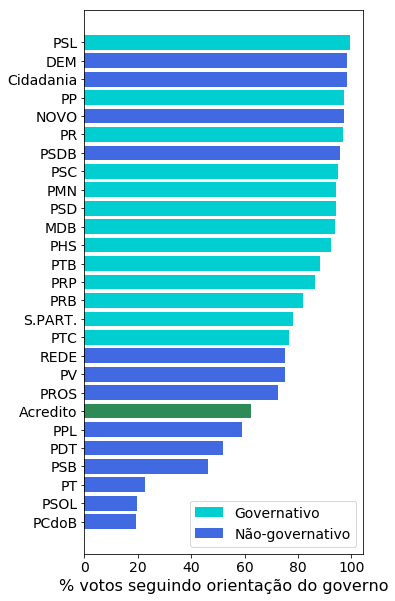

In [181]:
def fisioC(f):
    if f:
        return 'darkturquoise'
    else:
        return 'royalblue'
cores = map(fisioC,apoioByPartido.fisio.values)
cores[apoioByPartido.loc[apoioByPartido.partido=='Acredito'].index.values[0]] = 'seagreen'
x = np.arange(1,1+len(partidosAtuais)+1)
pl.figure(figsize=(5,10))
pl.barh(x,100*apoioByPartido.freq.values,color=cores)
pl.yticks(x,apoioByPartido.partido.values)
pl.xlabel(u'% votos seguindo orientação do governo', fontsize=16)
pl.gca().tick_params(labelsize=14)

# Legenda:
legend_elements = [Patch(facecolor='darkturquoise', label='Governativo'),
                   Patch(facecolor='royalblue',     label=u'Não-governativo')]

pl.legend(handles=legend_elements, fontsize=14, loc='lower right')

pl.show()
#saveFigWdate('graficos/apoio_ao_governo_partidos.pdf')

### Análise por deputado

In [17]:
orientGovAtual = v.loc[(v.partido_orientacao=='Governo') & (v.legislatura==56)]
grbyDep = orientGovAtual.groupby('deputado')

In [18]:
# Verifica id. de deputados com mais de um nome:
grbyDep['nome_deputado'].unique()[grbyDep['nome_deputado'].nunique()!=1]

deputado
204416    [Ubiratan Sanderson, Sanderson]
Name: nome_deputado, dtype: object

In [19]:
idTabata = v.loc[v.nome_deputado=='Tabata Amaral']['deputado'].unique()[0]
idFelipe = v.loc[v.nome_deputado=='Felipe Rigoni']['deputado'].unique()[0]
apoioTabata = grbyDep.get_group(idTabata)['apoio'].mean()*100
apoioFelipe = grbyDep.get_group(idFelipe)['apoio'].mean()*100

In [20]:
def depDistPlot(leg):
    orientGovAtual = v.loc[(v.partido_orientacao=='Governo') & (v.legislatura==leg)]
    grbyDep = orientGovAtual.groupby('deputado')
    apoioMedio = grbyDep['apoio'].mean().values*100
    pl.hist(apoioMedio,bins=20)
    pl.ylim([0,350])
    return np.median(apoioMedio)

512
513
520
524
511
376


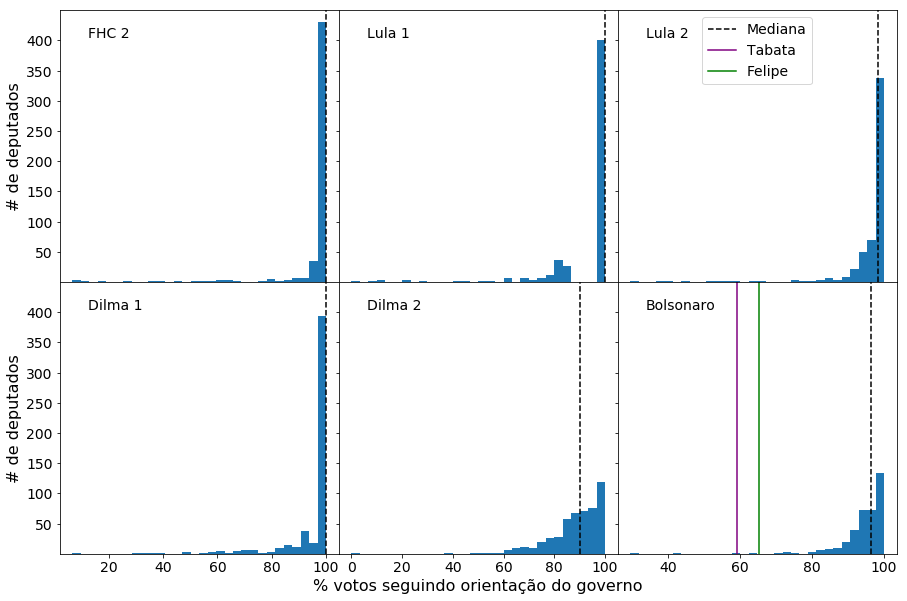

In [122]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.1,0.9,LegName[i],transform = pl.gca().transAxes, fontsize=14)
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        if (i==4): 
            pl.xlabel(u'% votos seguindo orientação do governo', fontsize=16)
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados', fontsize=16)
    # Plot:    
    median = depDistPlot(legList[i])
    pl.axvline(median,linestyle='--',color='k')
    # Coloca acredito:
    if legList[i]==56:
        pl.axvline(apoioTabata, color='purple')
        pl.axvline(apoioFelipe, color='g')
    pl.gca().tick_params(labelsize=14)
    pl.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))
    # Coloca legenda:
    if (i==2):
        import matplotlib.colors as colors 
        vertical_lines = [lines.Line2D([], [], color='k', linestyle='--', label='Mediana'),
                          lines.Line2D([], [], color=colors.to_rgba('purple', alpha=None), linestyle='-', label='Tabata'),
                          lines.Line2D([], [], color='g', linestyle='-', label='Felipe')]
        pl.legend(handles=vertical_lines, fontsize=14, loc='upper center')
    
pl.subplots_adjust(hspace=0,wspace=0)
pl.show()
#saveFigWdate('graficos/apoio_ao_governo_deputados.pdf')

### Análise por votação

In [36]:
xu.unique(v.sigla_tipo)

10:MPV,  MSC,  PDC,  PDL,  PEC,  PL,  PLP,  PRC,  REC,  REQ


In [37]:
# Conferindo que timestamp corresponde a uma única votação:
votosFavGovByDate = \
v.loc[v.partido_orientacao=='Governo'].sort_values('timestamp').groupby(['timestamp','resumo'])['apoio'].sum()

In [38]:
def lenEqSum(v):
    if len(v)==np.sum(v):
        return True
    else:
        return False

In [39]:
#v.loc[v.partido_orientacao=='Governo'].sort_values('timestamp').groupby(['timestamp','resumo'])\
#['apoio'].sum().sort_values(ascending=False)

In [40]:
t = v.loc[v.partido_orientacao=='Governo'].sort_values('timestamp').groupby(['timestamp','resumo'])\
['obj_votacao'].nunique()
lenEqSum(t)

True

In [41]:
anoVotacao    = np.array([x[0].year for x in votosFavGovByDate.index.values])
votosIdx      = np.arange(len(anoVotacao))
votoByVotacao = pd.DataFrame({'ano':anoVotacao, 'nvotos':np.array(votosFavGovByDate)})
grByAno       = votoByVotacao.groupby('ano')
nVotosMedio   = grByAno.mean().values

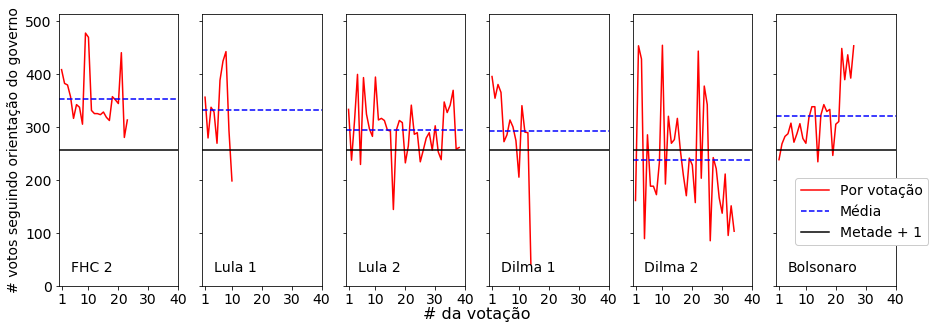

In [178]:
fig = pl.figure(figsize=(15,5))
anoUnique = votoByVotacao.ano.unique()
for i in range(len(anoUnique)):
    pl.subplot(1,len(anoUnique),i+1)
    # Text:
    pl.text(0.1,0.05, LegName[i], transform = pl.gca().transAxes, fontsize=14)
    y = grByAno.get_group(anoUnique[i]).values
    x = np.arange(1,1+len(y))
    pl.plot(x,y,'r-')
    pl.axhline(513/2+1, color='k')
    pl.axhline(nVotosMedio[i], color='blue', linestyle='--')
    # Format y:
    pl.ylim([0,513])
    if i>0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel(u'# votos seguindo orientação do governo', fontsize=14)
    pl.gca().tick_params(labelsize=14)
    pl.xticks([1,10,20,30,40])
    pl.xlim([0,40])
    
    # Label x comum:
    axComum = fig.add_subplot(111, frameon=False)
    pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axComum.set_xlabel(u'# da votação', fontsize=16)
    
    # Legenda:
    vertical_lines = [lines.Line2D([], [], color='red', linestyle='-', label=u'Por votação'),
                      lines.Line2D([], [], color='blue', linestyle='--', label=u'Média'),
                      lines.Line2D([], [], color='k', linestyle='-', label='Metade + 1')]
    pl.legend(handles=vertical_lines, fontsize=14, loc=(0.88,0.15), framealpha=1)
    
pl.show()
#saveFigWdate('graficos/apoio_ao_governo_por_votacao.pdf')

### Coesão partidária 

In [43]:
# Calcula tamanho médio na bancada no período:

depByLegPartido = v.loc[v.partido_deputado.isin(partidosAtuais)]\
[['legislatura','partido_deputado','deputado']].drop_duplicates()

nLegAtual    = len(np.array(legList)[np.array(legList)==56])
nLegAnterior = len(np.array(legList)[np.array(legList)<56])
nLegSDilma2  = len(np.array(legList)[np.array(legList)<55])

pSizeAtual    = depByLegPartido.loc[(depByLegPartido.legislatura==56)].groupby('partido_deputado')['deputado'].size()/nLegAtual
pSizeAnterior = depByLegPartido.loc[(depByLegPartido.legislatura<56)].groupby('partido_deputado')['deputado'].size()/nLegAnterior
pSizeSDilma2  = depByLegPartido.loc[(depByLegPartido.legislatura<55)].groupby('partido_deputado')['deputado'].size()/nLegSDilma2

In [44]:
# Prepara bases para extrair aderência à liderança dos partidos:
baseCoesao = v.loc[(v.partido_deputado.isin(partidosAtuais))&(v.partido_orientacao.isin(partidosAtuais))&
                   (v.partido_deputado==v.partido_orientacao)]
baseCoesaoAtual    = baseCoesao.loc[baseCoesao.legislatura==56]
baseCoesaoAnterior = baseCoesao.loc[baseCoesao.legislatura<56]
baseCoesaoSDilma2  = baseCoesao.loc[baseCoesao.legislatura<55]

In [45]:
# Calcula os apoios aos partidos nos períodos:
apoioAtual    =    baseCoesaoAtual.groupby('partido_deputado')['apoio'].mean()
apoioAnterior = baseCoesaoAnterior.groupby('partido_deputado')['apoio'].mean()
apoioSDilma2  =  baseCoesaoSDilma2.groupby('partido_deputado')['apoio'].mean()

In [46]:
def idxComplement(s1, s2):
    return np.array(list(set(s1.index.values)-set(s2.index.values)))

In [47]:
# Construindo base de fidelidade e poder:
apoioAtual.name    = 'atual'
apoioAnterior.name = 'anterior'
apoioSDilma2.name  = 'sdilma2'
pSizeAnterior.name = 'Nanterior'
pSizeSDilma2.name  = 'Nsdilma2'
pSizeAtual.name    = 'Natual'

In [48]:
apoioPartidos = pd.DataFrame()
apoioPartidos = apoioPartidos.join(apoioAtual,    how='outer')
apoioPartidos = apoioPartidos.join(apoioAnterior, how='outer')
apoioPartidos = apoioPartidos.join(apoioSDilma2,  how='outer')
apoioPartidos = apoioPartidos.join(pSizeAtual,    how='outer')
apoioPartidos = apoioPartidos.join(pSizeAnterior, how='outer')
apoioPartidos = apoioPartidos.join(pSizeSDilma2,  how='outer')

In [49]:
apoioPartidos['Patual']    = apoioPartidos[['atual']].fillna(apoioPartidos['atual'].mean())['atual']*apoioPartidos['Natual']
apoioPartidos['Panterior'] = apoioPartidos[['anterior']].fillna(apoioPartidos['anterior'].mean())['anterior']*apoioPartidos['Nanterior']
apoioPartidos['Psdilma2']  = apoioPartidos[['sdilma2']].fillna(apoioPartidos['sdilma2'].mean())['sdilma2']*apoioPartidos['Nsdilma2']

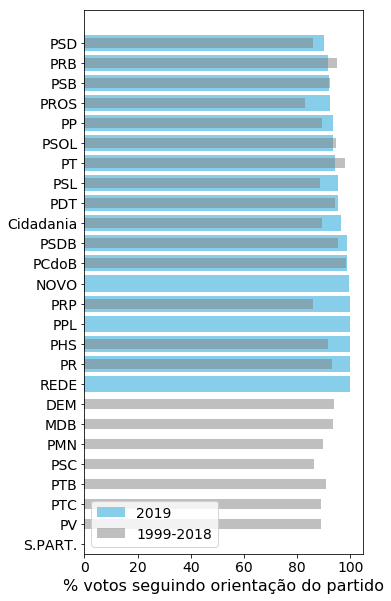

In [119]:
partidosSapoio = apoioPartidos.sort_values('atual')

pl.figure(figsize=(5,10))
x = np.arange(1,1+len(partidosSapoio))

pl.barh(x,partidosSapoio.atual[::-1]*100, color='skyblue', label='2019')
pl.barh(x,partidosSapoio.anterior[::-1]*100, height=0.5, color='gray', alpha=0.5, label='1999-2018')
#pl.bar(x,partidosSapoio.sdilma2*100, width=0.2, color='red', alpha=0.5)
pl.yticks(x,partidosSapoio.index.values[::-1])
pl.gca().tick_params(labelsize=14)
pl.xlabel(u'% votos seguindo orientação do partido', fontsize=16)
pl.legend(loc='lower left', fontsize=14)
pl.show()
#saveFigWdate('graficos/fidelidade_partidaria_media.pdf')

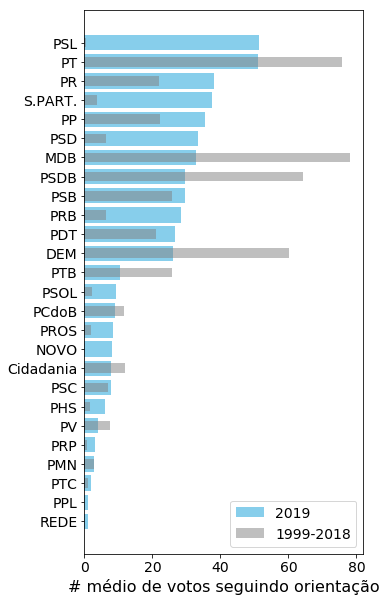

In [112]:
partidosSpoder = apoioPartidos.sort_values('Patual')

pl.figure(figsize=(5,10))
x = np.arange(1,1+len(partidosSpoder))

pl.barh(x,partidosSpoder.Patual, color='skyblue', label='2019')
pl.barh(x,partidosSpoder.Panterior, height=0.5, color='gray', alpha=0.5, label='1999-2018')
#pl.bar(x,partidosSpoder.sdilma2, width=0.2, color='red', alpha=0.5)
pl.yticks(x,partidosSpoder.index.values)

pl.gca().tick_params(labelsize=14)
#pl.grid(color='lightgray')
pl.xlabel(u'# médio de votos seguindo orientação', fontsize=16)
pl.legend(loc='lower right', fontsize=14)

pl.show()
#saveFigWdate('graficos/poder_partidario.pdf')

### Fidelidade partidária (por deputados)

In [75]:
def depDistPlot(leg):
    orientPartido = v.loc[(v.partido_orientacao==v.partido_deputado) & (v.legislatura==leg)]
    grbyDep = orientPartido.groupby('deputado')
    apoioMedio = grbyDep['apoio'].mean().values*100
    pl.hist(apoioMedio,bins=30)
    pl.ylim([0,450])
    print len(apoioMedio)
    return np.median(apoioMedio)

In [76]:
orientPartAtual = v.loc[(v.partido_orientacao==v.partido_deputado) & (v.legislatura==56)]
grbyDep = orientPartAtual.groupby('deputado')
fidTabata = grbyDep.get_group(idTabata)['apoio'].mean()*100
fidFelipe = grbyDep.get_group(idFelipe)['apoio'].mean()*100

512
513
520
524
511
376


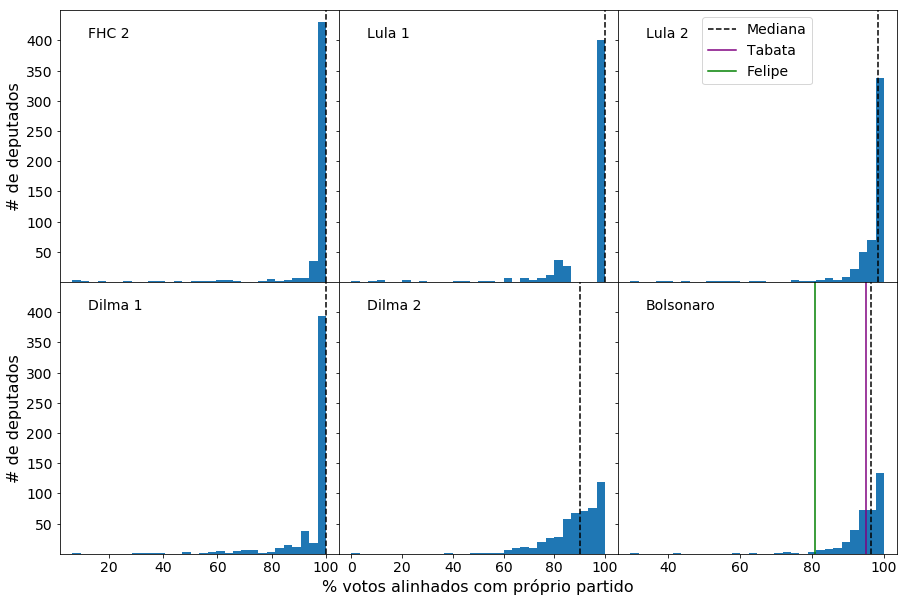

In [114]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.1,0.9,LegName[i],transform = pl.gca().transAxes, fontsize=14)
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        if (i==4):
            pl.xlabel(u'% votos alinhados com próprio partido', fontsize=16)
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados', fontsize=16)
    # Plot:    
    median = depDistPlot(legList[i])
    pl.axvline(median,linestyle='--',color='k')
    # Coloca acredito:
    if legList[i]==56:
        pl.axvline(fidTabata, color='purple')
        pl.axvline(fidFelipe, color='g')
    pl.gca().tick_params(labelsize=14)
    pl.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))
    # Coloca legenda:
    if (i==2):
        import matplotlib.colors as colors 
        vertical_lines = [lines.Line2D([], [], color='k', linestyle='--', label='Mediana'),
                          lines.Line2D([], [], color=colors.to_rgba('purple', alpha=None), linestyle='-', label='Tabata'),
                          lines.Line2D([], [], color='g', linestyle='-', label='Felipe')]
        pl.legend(handles=vertical_lines, fontsize=14, loc='upper center')

pl.subplots_adjust(hspace=0,wspace=0)
pl.show()
#saveFigWdate('graficos/fidelidade_partidaria_deputados.pdf')

### Lixo

In [ ]:
print xu.unique(v.partido_orientacao)
print xu.unique(v.legislatura)
print xu.freq(v.voto,'Obstrução'), xu.freq(v.orientacao,'Obstrução')
print xu.freq(v.voto,'Sim'), xu.freq(v.orientacao,'Sim')
print xu.freq(v.voto,'Não'), xu.freq(v.orientacao,'Não')

In [ ]:
listaLegislatura = sorted(v.legislatura.unique())
anoLegislatura   = 2019 - 4*(56-np.array(listaLegislatura))

def histApoio(mandante, partido=None):
    return np.array([freqApoio(l, mandante, partido) for l in listaLegislatura])

In [ ]:
def histBarPlot(mandante, partido=None):
    x = np.arange(1,1+len(anoLegislatura))
    y = 100*histApoio(mandante,partido)
    pl.bar(x,y)
    pl.xticks(x, anoLegislatura)
    pl.xlabel('Ano')
    pl.ylabel('% de apoio')
    if partido==None:
        pl.title(mandante+' orienta geral')
    else:
        pl.title(mandante+' orienta '+partido)
    pl.ylim([0,105])

In [ ]:
pl.figure(figsize=(6*2.5,6*2.5))
for n in range(36):
    pl.subplot(6,6,n+1)
    histBarPlot('Governo', sorted(v.partido_deputado.unique())[1+n])
pl.tight_layout()
pl.show()

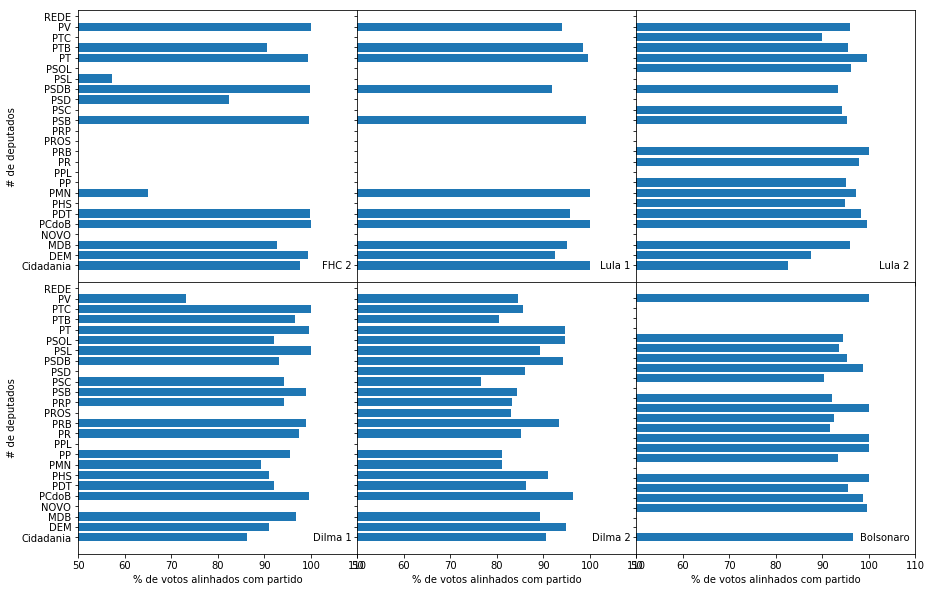

In [205]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3


x = np.arange(1,len(partidosAtuais))
apoioMin = int(coesaoByLegPartido.apoio.min()*10)*10

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.98,0.05,LegName[i],transform = pl.gca().transAxes, ha='right')
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        pl.xlabel('% de votos alinhados com governo')
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados')
    # Plot:
    pl.barh(x,100*pivotCoesao[legList[i]].values)
    pl.yticks(x,pivotCoesao[legList[i]].index.values)
    pl.xlabel('% de votos alinhados com partido')
    pl.xlim([apoioMin,110])
    # Coloca acredito:
    #if legList[i]==56:
    
    
pl.subplots_adjust(hspace=0,wspace=0)
pl.show()